# DBScan Example

https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31

In [1]:
# import libraries
import functions
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.express as px
plt.style.use('fivethirtyeight')
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

from warnings import filterwarnings
filterwarnings('ignore')

## Load Data

In [2]:
with open('HR_data.csv') as f:
    df =  pd.read_csv(f, usecols=['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years'])
f.close()
print(df.shape)
df.head()

(14999, 7)


satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  promotion_last_5years  
0                   3              0                      0  
1                   6              0                      0  
2                   4              0                      0  
3                   5              0                      0  
4                   3              0                      0

## Standardization

Since the features in our dataset are not on the same scale we need to standardize the entire dataset. In other words, each feature in our dataset has unique magnitudes and range for their data. A one-point increase in Satisfaction_level does not equal a one-point increase in Last_evaluation and vice versa. Since DBSCAN utilizes the distance (Euclidean) between points to determine similarity, unscaled data creates a problem. If one feature has higher variability in its data the distance calculation will be more affected by that feature. By scaling our features we align all the features to a mean of zero and a standard deviation of one.

In [3]:
scaler = StandardScaler()
scaler.fit(df)
X_scale = scaler.transform(df)
X_scale

array([[-0.93649469, -1.08727529, -1.46286291, ..., -0.34123516,
        -0.41116529, -0.14741182],
       [ 0.75281433,  0.84070693,  0.97111292, ...,  1.71343614,
        -0.41116529, -0.14741182],
       [-2.02247906,  0.95755433,  2.59376348, ...,  0.34365527,
        -0.41116529, -0.14741182],
       ...,
       [-0.97671633, -1.08727529, -1.46286291, ..., -0.34123516,
        -0.41116529, -0.14741182],
       [-2.02247906,  1.42494396,  1.7824382 , ...,  0.34365527,
        -0.41116529, -0.14741182],
       [-0.97671633, -1.14569899, -1.46286291, ..., -0.34123516,
        -0.41116529, -0.14741182]])

In [4]:
# Change numpy array (scaled data) to a dataframe with the same column names as the original df
df_scale = pd.DataFrame(X_scale, columns=df.columns)
df_scale.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0           -0.936495        -1.087275       -1.462863             -0.882040   
1            0.752814         0.840707        0.971113              1.220423   
2           -2.022479         0.957554        2.593763              1.420657   
3            0.431041         0.899131        0.971113              0.439508   
4           -0.976716        -1.145699       -1.462863             -0.841993   

   time_spend_company  Work_accident  promotion_last_5years  
0           -0.341235      -0.411165              -0.147412  
1            1.713436      -0.411165              -0.147412  
2            0.343655      -0.411165              -0.147412  
3            1.028546      -0.411165              -0.147412  
4           -0.341235      -0.411165              -0.147412

## Feature Reduction

Some algorithms such as KMeans find it difficult to accurately construct clusters if the dataset has too many features (ie. high dimensionality). High dimensionality does not necessarily mean hundreds or even thousands of features. Even 10 features can create accuracy issues.

The theory behind feature or dimensionality reduction is to convert the original feature set into fewer artificially derived features which still maintain most of the information encompassed in the original features.

One of the most prevalent feature reduction techniques is Principal Component Analysis or PCA. PCA reduces the original dataset into a specified number of features which PCA calls principal components. We have to select the number of principal components we wish to see. We discuss feature reduction in my article on KMeans clustering and I strongly advise you to take a look (LINK).

First, we need to determine the appropriate number of principal components. It would seem that 4 principal components account for roughly 75% of the variance.

In [5]:
# Scree plot uses the functions library that comes with this exercise
# Red is cumsum. Blue bars are individual components.
pca = PCA(n_components=7) # 7 features possible
pca.fit(df_scale)
functions.display_scree_plot(pca)

In [6]:
# Using cumsum you don't have to do the math. 
pca.explained_variance_ratio_.cumsum().round(2)

array([0.26, 0.42, 0.57, 0.71, 0.83, 0.92, 1.  ])

The first explains 26%, the first 2 explain 42%, the first 3 explain 57% and so on. Ypu typically want at least 80% of the variance explained. In this case that is 5 components (83%). 

Now that we know the number of principal components needed to maintain a specific percentage of variance let’s apply a 5 component PCA to our original dataset. Notice that the first principal component accounts for 26% of the variance from the original dataset. 

In [7]:
pca = PCA(n_components=4)
pca.fit(df_scale)
pca_scale = pca.transform(df_scale)
pca_df = pd.DataFrame(pca_scale, columns=['pc1', 'pc2', 'pc3', 'pc4'])
print(pca.explained_variance_ratio_)
pca_df.head()

[0.26143604 0.16093156 0.1514701  0.13656039]


pc1       pc2       pc3       pc4
0 -1.900350 -1.120831 -0.079779  0.032284
1  2.135832  0.249337  0.093616  0.506769
2  3.058916 -1.683127 -0.301682 -0.448864
3  1.550277  0.125511 -0.091630  0.407445
4 -1.904444 -1.168134 -0.072386  0.014660

### Plotting

Plotting our data in a 4D space we can see some potential problems for DBSCAN. If you recall one of the main cons for DBSCAN is its inability to accurately cluster data of varying density and from the plot below we can see two separate clusters of very different density. Upon applying the DBSCAN algorithm we might be able to find clusters in the lower cluster of data points but many of the data points in the upper cluster might be classified as outliers/noise. This is of course all dependent on our selection of epsilon and minimum point values. We are using 4 components for this plot. Plotly also has the ability to let you rotate the plot which can give you additional information.

In [8]:
# original
scene = dict(xaxis = dict(title  = 'PC1'),
             yaxis = dict(title  = 'PC2'),
             zaxis = dict(title  = 'PC3'))

trace = go.Scatter3d(x=pca_df.iloc[:,0], 
                     y=pca_df.iloc[:,1], 
                     z=pca_df.iloc[:,2], 
                     mode='markers',
                     marker=dict(color = pca_df['pc4'],
                                 opacity = 0.3, 
                                 size = 10,
                                 colorscale='Plasma'))

layout = go.Layout(margin=dict(l=0,r=0),
                   scene = scene, 
                   height = 900,
                   width = 900)

data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show();

Lets look at it with 4 dimensions using matplotlib. Unfortunately, NO ability to rotate plot with matplotlib but still instructive.

In [9]:
fig = plt.figure(figsize=(10,10))
cm = plt.cm.get_cmap('viridis')
ax = fig.add_subplot(111, projection='3d')
sp = ax.scatter(pca_df['pc1'],
                pca_df['pc2'],
                pca_df['pc3'], 
                c=pca_df['pc4'],
                s=20,
                cmap=cm)
plt.colorbar(sp);

With the 3 dimensional plotly plot it looks like 4 clusters. With the 4d plot with matplotlib it looks like 5 clusters.

## DBSCAN Clustering

### Elbow Method (Approach 1)

Before we apply the clustering algorithm we have to determine the appropriate epsilon level using the “Elbow Method” we discussed above. 

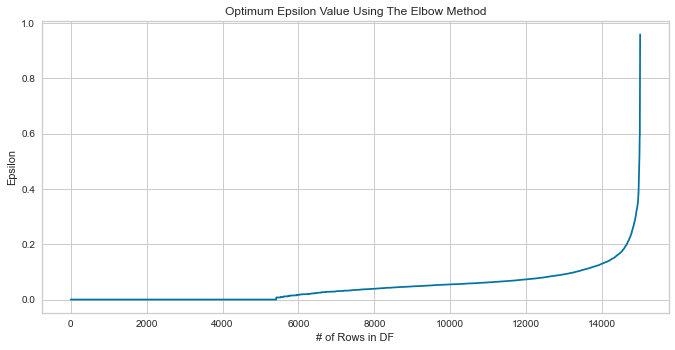

In [10]:
plt.figure(figsize=(10,5))
plt.title('Optimum Epsilon Value Using The Elbow Method')
plt.xlabel('# of Rows in DF')
plt.ylabel('Epsilon')
nn = NearestNeighbors(n_neighbors=5).fit(pca_df)
distances, idx = nn.kneighbors(pca_df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

It would seem the optimal epsilon value is around 0.2. Finally, since we have 4 principal components to our data we’ll set our minimum points criteria to 8. That is double the number of components.

In [11]:
db = DBSCAN(eps=0.2, min_samples=8).fit(pca_df)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(pca_df, labels))

Estimated number of clusters: 57
Estimated number of noise points: 2472
Silhouette Coefficient: -0.377


Not very useful to have 57 clusters. You want to group employees. 57 clusters is waay too many. Typically 3 clusters (gold, silver, bronze) or perhaps a few more (e.g. 5). A silhouette score of -.377 is awful. 

### Hyperparameter Tuning (Approach 2)

Instead of using the “Elbow Method” and the minimum value heuristic let’s take an iterative approach to fine-tuning our DBSCAN model. We are going to iterate through a range of epsilon and minimum point values as we apply the DBSCAN algorithm to our data.

We are going to iterate through epsilon values ranging from 0.2 to 3 at 0.2 intervals and minimum point values ranging from 2–10 . The for-loop will run the DBSCAN algorithm using the set of values and produce the number of clusters and silhouette score for each iteration. Keep in mind you will need to adjust your parameters according to your data. You might run this code on one set of parameters and find that the best silhouette score produced is 0.30. You might want to increase the epsilon value in order to encompass more points into a cluster.

In [12]:
pca_eps_values = np.arange(0.2,3.1,0.2) 
pca_min_samples = np.arange(2,11,2) 
pca_dbscan_params = list(itertools.product(pca_eps_values, pca_min_samples))

pca_no_of_clusters = []
pca_sil_score = []
pca_epsvalues = []
pca_min_samp = []

for p in pca_dbscan_params:
    
    pca_dbscan_cluster = DBSCAN(eps=p[0], 
                                min_samples=p[1], 
                                n_jobs=-1).fit(pca_df)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_sil_score.append(silhouette_score(pca_df, pca_dbscan_cluster.labels_))

pca_eps_min_df = pd.DataFrame({'no_of_clusters': pca_no_of_clusters, 
                     'silhouette_score': pca_sil_score,
                     'epsilon_values': pca_epsvalues,
                     'minimum_points': pca_min_samp})

In [13]:
pca_eps_min_df.head()

no_of_clusters  silhouette_score  epsilon_values  minimum_points
0             552         -0.415164             0.2               2
1             147         -0.457949             0.2               4
2              92         -0.450958             0.2               6
3              58         -0.376615             0.2               8
4              44         -0.330775             0.2              10

In [14]:
# Looks at number of clusters and see if there are tractable values
sorted(pca_eps_min_df['no_of_clusters'].unique())

[2, 3, 4, 5, 6, 8, 9, 11, 13, 14, 20, 26, 33, 44, 55, 58, 92, 114, 147, 552]

In [15]:
# Lets reduce the possiblities to between 4 and 9 clusters.
db_df = pca_eps_min_df[(pca_eps_min_df['no_of_clusters'] \
                        >= 4) & (pca_eps_min_df['no_of_clusters'] <= 9)]
db_df.head()

no_of_clusters  silhouette_score  epsilon_values  minimum_points
9                9          0.127363             0.4              10
12               8          0.342935             0.6               6
13               5          0.399118             0.6               8
14               5          0.397606             0.6              10
17               5          0.402618             0.8               6

In [16]:
# Lets see what the range of silhouette scores is in this df.
sorted(db_df['silhouette_score'].unique())

[0.12736305990308902,
 0.3429346431600674,
 0.39279639637087305,
 0.39760572801921756,
 0.3991179957343648,
 0.40196867902715677,
 0.4020113516972429,
 0.4026075530774174,
 0.402617973086287,
 0.40398855461065813,
 0.40403554736691033,
 0.40449997788906267,
 0.4045844680078775,
 0.40470077909478974,
 0.4047589213286589,
 0.4051454411958247]

~ .4 something is the largest so that is the best we are going to do.

In [17]:
# Lets sort descending from silhouette score, then clusters, then minimum points
db_df.sort_values(by=['silhouette_score', 'no_of_clusters', 'epsilon_values', 'minimum_points'], 
                  ascending=False,
                  ignore_index=True, 
                  inplace=True)
db_df

no_of_clusters  silhouette_score  epsilon_values  minimum_points
0                4          0.405145             2.4              10
1                4          0.405145             2.4               8
2                4          0.405145             2.4               6
3                4          0.405145             2.4               4
4                4          0.405145             2.4               2
5                4          0.405145             2.2              10
6                4          0.405145             2.2               8
7                4          0.405145             2.2               6
8                4          0.405145             2.2               4
9                4          0.405145             2.2               2
10               4          0.405145             2.0              10
11               4          0.405145             2.0               8
12               4          0.405145             2.0               6
13               4          0.405145             2.0               4
14               4          0.405145             2.0               2
15               4          0.405145             1.8              10
16               4          0.405145             1.8               8
17               4          0.405145             1.8               6
18               4          0.405145             1.8               4
19               4          0.405145             1.8               2
20               4          0.405145             1.6              10
21               4          0.405145             1.6               8
22               4          0.405145             1.6               6
23               4          0.405145             1.6               4
24               4          0.405145             1.6               2
25               4          0.405145             1.4               6
26               4          0.405145             1.4               4
27               4          0.405145             1.4               2
28               5          0.404759             1.4               8
29               5          0.404701             1.4              10
30               5          0.404584             1.2               8
31               5          0.404500             1.2              10
32               5          0.404036             1.0               6
33               5          0.403989             1.0               8
34               5          0.402618             0.8               6
35               6          0.402608             1.0              10
36               5          0.402011             0.8               8
37               5          0.401969             0.8              10
38               5          0.399118             0.6               8
39               5          0.397606             0.6              10
40               5          0.392796             1.2               6
41               5          0.392796             1.2               4
42               5          0.392796             1.2               2
43               8          0.342935             0.6               6
44               9          0.127363             0.4              10

## Kmeans Clustering Alternative

Lets see if we can do any better with kmeans

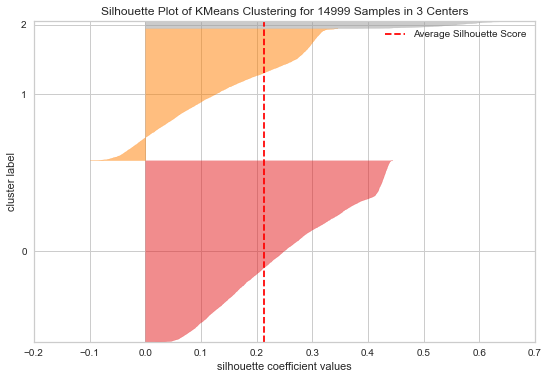

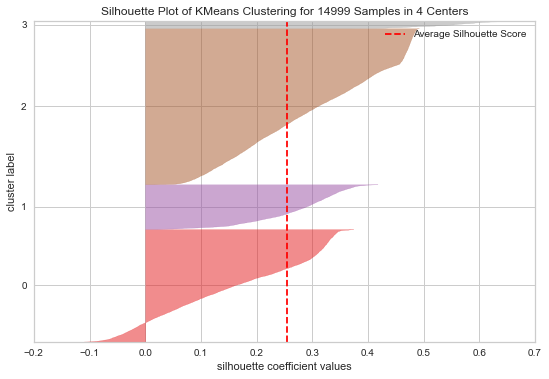

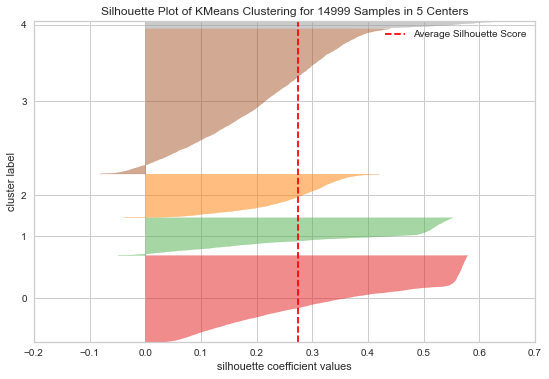

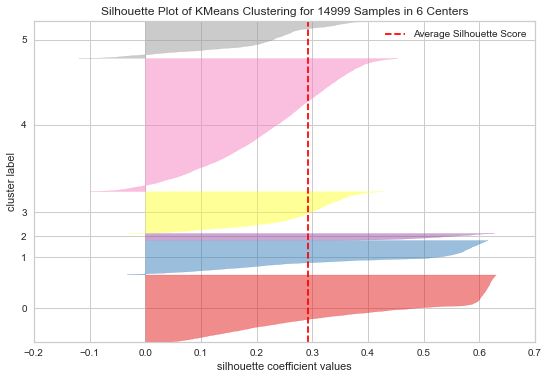

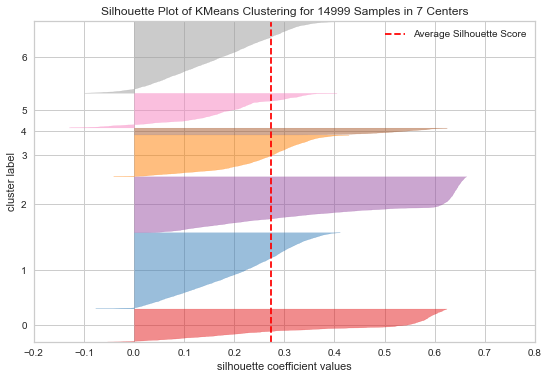

In [18]:
for cls_num in range(2,10):
    model = SilhouetteVisualizer(KMeans(cls_num))
    model.fit(df_scale)
    model.show()

## Choose Model

Based on the above, DBscan is better than Kmeans since its silhouete score is better (.4 vs .3). Lets choose 4 clusters, an epsilon of 1.4, and 6 as the minimun number of points for DBscan.

In [19]:
db = DBSCAN(eps=1.4, min_samples=6, n_jobs=-1).fit(pca_df)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(pca_df, labels))

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.405


That is really good. No noise points!

In [20]:
Scene = dict(xaxis = dict(title  = 'PC1'),
             yaxis = dict(title  = 'PC2'),
             zaxis = dict(title  = 'PC3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = db.labels_
trace = go.Scatter3d(x=pca_df.iloc[:,0], 
                     y=pca_df.iloc[:,1], 
                     z=pca_df.iloc[:,2], 
                     mode='markers',
                     marker=dict(color = labels, 
                                 colorscale='Viridis', 
                                 size = 10, 
                                 line = dict(color = 'gray',width = 5)))

layout = go.Layout(scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title='DBSCAN Clusters (4) Derived from PCA', font=dict(size=12,))
fig.show()

Excellent. Very sharp clusters!

Count the number of employees in each cluster. 

In [21]:
# All that we have right now is an array with 14,999 row and a value for the cluster for each row.
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([12587,    76,  2093,   243], dtype=int64))

A couple of large clusters (especially cluster 0). Whether or not this is helpful, depends on the 'ruler' which, I guess could be the promotions column?

In [22]:
df_scale['cluster'] = labels
df_scale.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0           -0.936495        -1.087275       -1.462863             -0.882040   
1            0.752814         0.840707        0.971113              1.220423   
2           -2.022479         0.957554        2.593763              1.420657   
3            0.431041         0.899131        0.971113              0.439508   
4           -0.976716        -1.145699       -1.462863             -0.841993   

   time_spend_company  Work_accident  promotion_last_5years  cluster  
0           -0.341235      -0.411165              -0.147412        0  
1            1.713436      -0.411165              -0.147412        0  
2            0.343655      -0.411165              -0.147412        0  
3            1.028546      -0.411165              -0.147412        0  
4           -0.341235      -0.411165              -0.147412        0

In [34]:
df_med = df_scale.groupby('cluster').median()
df_med.reset_index(inplace=True)
df_med

cluster  satisfaction_level  last_evaluation  number_project  \
0        0            0.109268         0.022775        0.159788   
1        1            0.149490         0.373317        0.159788   
2        2            0.229933        -0.035649        0.159788   
3        3            0.390820        -0.094072        0.159788   

   average_montly_hours  time_spend_company  Work_accident  \
0             -0.021031           -0.341235      -0.411165   
1              0.419485           -0.341235       2.432112   
2             -0.041055           -0.341235       2.432112   
3             -0.101125           -0.341235      -0.411165   

   promotion_last_5years  
0              -0.147412  
1               6.783716  
2              -0.147412  
3               6.783716

In [35]:
functions.display_parallel_coordinates_centroids(df_mean, len(df_med))

## Conclusion

Again, this points to the continual challenge of interpreting the results. If you assume that 'promotion_last_5_years" is the ruler. That means we are looking at the red and orange lines. Then may or may not have an accident is interesting (not), time spent with compay, again some good some bad. Really difficult to draw any interesting conclusions from this data.

## Limitations

No ruler of interest:(